In [30]:
import os, re, json, tarfile
import numpy as np
import tensorflow as tf

In [31]:
filenames = [
        'qa1_single-supporting-fact',
        'qa2_two-supporting-facts',
        'qa3_three-supporting-facts',
        'qa4_two-arg-relations',
        'qa5_three-arg-relations',
        'qa6_yes-no-questions',
        'qa7_counting',
        'qa8_lists-sets',
        'qa9_simple-negation',
        'qa10_indefinite-knowledge',
        'qa11_basic-coreference',
        'qa12_conjunction',
        'qa13_compound-coreference',
        'qa14_time-reasoning',
        'qa15_basic-deduction',
        'qa16_basic-induction',
        'qa17_positional-reasoning',
        'qa18_size-reasoning',
        'qa19_path-finding',
        'qa20_agents-motivations',
]

In [32]:
source_dir = "/notebooks/Share/dataset/babi/tasks_1-20_v1-2/en-10k/"
dest_dir = "/notebooks/Share/dataset/babi/processed/"

EXTRA_TOKENS = ["<PAD>", "<GO>", "<EOS>"]
SPLIT_PROG = re.compile("(\W+)?")

In [4]:
def tokenize(sentence):
    return [
        token.strip().lower() 
        for token in re.split(SPLIT_PROG, sentence) if token.strip()]

In [5]:
def parse_stories(lines):
    stories = []
    story = []
    for line in lines:
        if line.strip():
            line = line.decode('utf-8').strip()
            nid, line = line.split(' ', 1)
            nid = int(nid)
            if nid == 1:
                story = []
                counter = 0
                nid_mapping = {1:0}
            if '\t' in line:
                query, answer, supporting = line.split('\t')
                query = tokenize(query) + ["<EOS>"]
                answer = tokenize(answer) + ["<EOS>"]
                substory = None
                # Provide all the substories
                substory = [x for x in story if x]
                supporting = [nid_mapping[int(x)]
                              for x in supporting.split(" ")]
                stories.append((substory, query, answer, supporting))
            else:
                sentence = tokenize(line) + ["<EOS>"]
                nid_mapping[nid] = counter
                story.append(sentence)
                counter += 1
    return stories

In [6]:
def tokenize_stories(stories, encode_dict):
    story_ids = []
    for story, query, answer, sup in stories:
        story = [[encode_dict[token] for token in sentence]
                 for sentence in story]
        query = [encode_dict[token] for token in query]
        answer = [encode_dict[token] for token in answer]
        story_ids.append((story, query, answer, sup))
    return story_ids

In [7]:
def build_token_set(stories):
    tokens_all = EXTRA_TOKENS
    for story, query, answer, sup in stories:
        tokens_all.extend([token for sentence in story for token in sentence] + query + answer)
    return set(tokens_all)

In [8]:
def build_encode_decode_dict(token_set):
    vocab = sorted(token_set)
    encode_dict = {token: (i + 1) for i, token in enumerate(vocab)}
    decode_dict = {(i + 1): token for i, token in enumerate(vocab)}
    return encode_dict, decode_dict    

In [9]:
def pad_stories(stories, max_sentence_length, max_story_length, max_query_length, max_ans_length, pad_encoding):
    for story, query, answer, sup in stories:
        for sentence in story:
            for _ in range(max_sentence_length - len(sentence)):
                sentence.append(pad_encoding)
            assert len(sentence) == max_sentence_length

        for _ in range(max_story_length - len(story)):
            story.append([pad_encoding for _ in range(max_sentence_length)])

        for _ in range(max_query_length - len(query)):
            query.append(pad_encoding)
            
        for _ in range(max_ans_length - len(answer)):
            answer.append(pad_encoding)

        assert len(story) == max_story_length
        assert len(query) == max_query_length
        assert len(answer) == max_ans_length

    return stories

In [10]:
def truncate_stories(stories, max_length):
    stories_truncated = []
    for story, query, answer, sup in stories:
        story_truncated = story[-max_length:]
        stories_truncated.append((story_truncated, query, answer, sup))
    return stories_truncated

In [11]:
def save_dataset(stories, path):
    dataset = []
    for story, query, answer, sup in stories:
        story_arr = np.array(story, dtype=np.int)
        query_arr = np.array(query, dtype=np.int)
        answer_arr = np.array(answer, dtype=np.int)
        sup_arr = np.array(sup, dtype=np.int)
        
        example = np.array([story_arr, query_arr, answer_arr, sup_arr])
        dataset.append(example)
        
    np.save(path, np.array(dataset))

In [12]:
token_set = set()
stories = []
for filename in filenames:
    stories_path_train = os.path.join(source_dir, filename + '_train.txt')
    stories_path_test = os.path.join(source_dir, filename + '_test.txt')
    dataset_size = 10000
    
    # From the entity networks paper:
    # > Copying previous works (Sukhbaatar et al., 2015; Xiong et al., 2016), the capacity of the memory
    # > was limited to the most recent 70 sentences, except for task 3 which was limited to 130 sentences.
    if filename == 'qa3_three-supporting-facts':
        truncated_story_length = 130
    else:
        truncated_story_length = 70

    f_train = open(stories_path_train)
    f_test = open(stories_path_test)
            
    stories_train = parse_stories(f_train.readlines())
    stories_test = parse_stories(f_test.readlines())
        
    stories_train = truncate_stories(stories_train, truncated_story_length)
    stories_test = truncate_stories(stories_test, truncated_story_length)
    
    stories.append((stories_train, stories_test))
    
    token_set.update(build_token_set(stories_train + stories_test))

encode_dict, decode_dict = build_encode_decode_dict(token_set)
print(len(encode_dict))

for ((stories_train, stories_test), filename) in zip(stories, filenames):
    
    dataset_path_train = os.path.join(dest_dir, filename + '_train.npy')
    dataset_path_test = os.path.join(dest_dir, filename + '_test.npy')
    metadata_path = os.path.join(dest_dir, filename + '_meta.npy')
    


    stories_token_train = tokenize_stories(stories_train, encode_dict)
    stories_token_test = tokenize_stories(stories_test, encode_dict)
    stories_token_all = stories_token_train + stories_token_test

    max_sentence_length = max([len(sentence) for story, _, _, _ in stories_token_all for sentence in story])
    max_story_length = max(len(story) for story, _, _, _ in stories_token_all)
    max_query_length = max(len(query) for _, query, _, _ in stories_token_all)
    max_ans_length = max(len(ans) for _, _, ans, _ in stories_token_all)
    vocab_size = len(encode_dict)


    metadata = {
                'dataset_name': filename,
                'dataset_size': dataset_size,
                'max_sentence_length': max_sentence_length,
                'max_story_length': max_story_length,
                'max_query_length': max_query_length,
                'max_ans_length': max_ans_length,
                'vocab_size': vocab_size + 1,
                'tokens': encode_dict,
                'decode': decode_dict,
                'datasets': {
                    'train': os.path.basename(dataset_path_train),
                    'test': os.path.basename(dataset_path_test),
                }
    }
    np.save(metadata_path, np.array(metadata))

    stories_pad_train = pad_stories(stories_token_train, max_sentence_length,
        max_story_length, max_query_length, max_ans_length, encode_dict["<PAD>"])
    stories_pad_test = pad_stories(stories_token_test, max_sentence_length, 
        max_story_length, max_query_length, max_ans_length, encode_dict["<PAD>"])
    


    save_dataset(stories_pad_train, dataset_path_train)
    save_dataset(stories_pad_test, dataset_path_test)
    
    print("{} dataset is ready".format(filename))

162
qa1_single-supporting-fact dataset is ready
qa2_two-supporting-facts dataset is ready
qa3_three-supporting-facts dataset is ready
qa4_two-arg-relations dataset is ready
qa5_three-arg-relations dataset is ready
qa6_yes-no-questions dataset is ready
qa7_counting dataset is ready
qa8_lists-sets dataset is ready
qa9_simple-negation dataset is ready
qa10_indefinite-knowledge dataset is ready
qa11_basic-coreference dataset is ready
qa12_conjunction dataset is ready
qa13_compound-coreference dataset is ready
qa14_time-reasoning dataset is ready
qa15_basic-deduction dataset is ready
qa16_basic-induction dataset is ready
qa17_positional-reasoning dataset is ready
qa18_size-reasoning dataset is ready
qa19_path-finding dataset is ready
qa20_agents-motivations dataset is ready


In [34]:
prefix = dest_dir + filenames[-1]
meta = np.load(prefix + "_meta.npy")[None][0]

In [35]:
training_path = dest_dir + meta['datasets']['train']
test_path = dest_dir + meta['datasets']['test']

training_set = np.load(training_path)
test_set = np.load(test_path)
print test_set.shape

(1000, 4)


In [17]:
story, query, ans, sup = test_set[10]
print("\n".join(str(" ".join(meta["decode"][token] for token in line)) for line in story))
print(" ".join(meta["decode"][token] for token in query))
print(" ".join(meta["decode"][token] for token in ans))
print(sup)

jason is thirsty . <EOS> <PAD> <PAD> <PAD>
antoine is bored . <EOS> <PAD> <PAD> <PAD>
jason went to the kitchen . <EOS> <PAD>
antoine journeyed to the garden . <EOS> <PAD>
sumit is hungry . <EOS> <PAD> <PAD> <PAD>
antoine grabbed the football there . <EOS> <PAD>
sumit went to the kitchen . <EOS> <PAD>
jason took the milk there . <EOS> <PAD>
sumit took the apple there . <EOS> <PAD>
yann is thirsty . <EOS> <PAD> <PAD> <PAD>
yann travelled to the kitchen . <EOS> <PAD>
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
why did yann go to the kitchen ? <EOS>
thirsty <EOS>
[9]


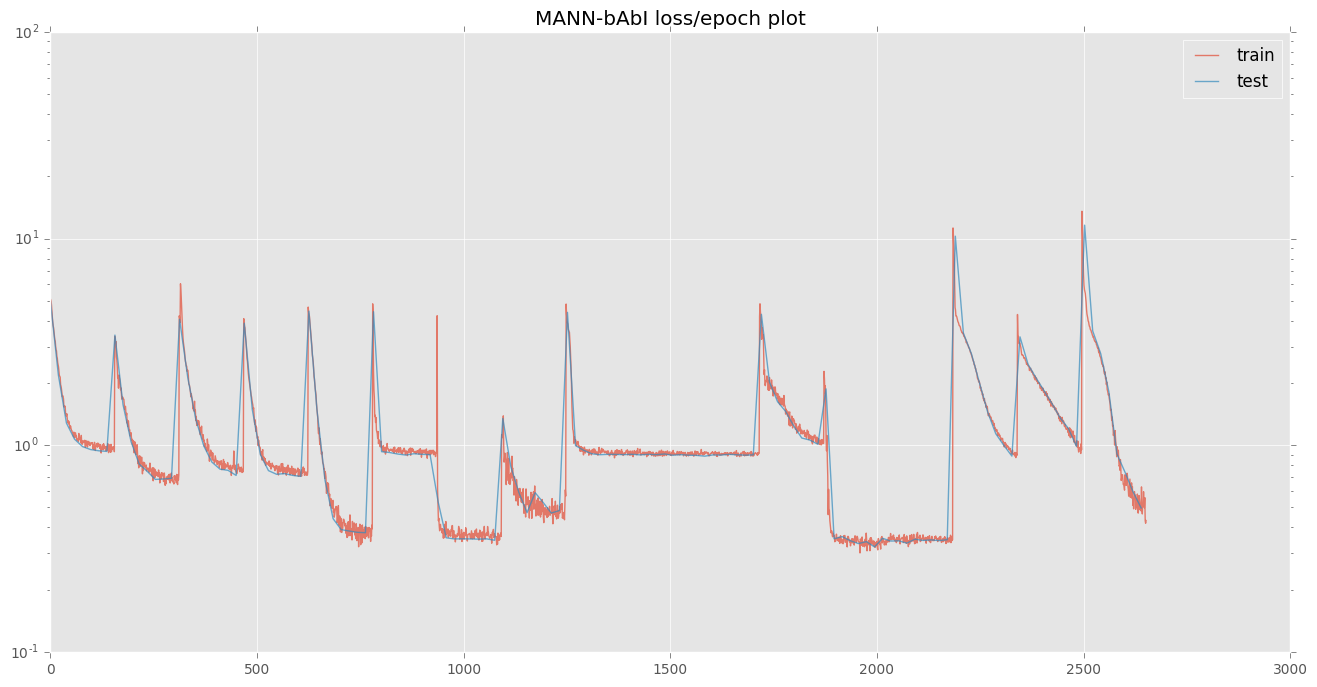

In [27]:
%matplotlib inline
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

plt.style.use("ggplot")

filenames = [
    'qa1_single-supporting-fact',
    'qa20_agents-motivations',
    'qa15_basic-deduction',
    'qa16_basic-induction',
    'qa9_simple-negation',
    'qa4_two-arg-relations',
    'qa6_yes-no-questions',
    'qa10_indefinite-knowledge',
    'qa11_basic-coreference',
    'qa12_conjunction',
    'qa13_compound-coreference',
    'qa14_time-reasoning',
    'qa17_positional-reasoning',
    'qa18_size-reasoning',
    'qa19_path-finding']

total_train = []
total_test = []

for filename in filenames:
    train_curve = np.load("./{}_train_curve_full.npy".format(filename))
    test_curve = np.load("./{}_test_curve_full.npy".format(filename))
    
    total_train.append(train_curve)
    total_test.append(test_curve)
    
filenames = [
    'qa7_counting',
    'qa8_lists-sets'
]

for filename in filenames:
    train_curve = np.load("./{}_train_curve_full_1.npy".format(filename))
    test_curve = np.load("./{}_test_curve_full_1.npy".format(filename))
    
    total_train.append(train_curve)
    total_test.append(test_curve)
    
train = np.concatenate(total_train, axis=0)
test = np.concatenate(total_test, axis=0)


test_x = np.array([19.55 * x for x in range(len(test))])
    
plt.figure(figsize=(16, 8), dpi=80)
plt.title("MANN-bAbI loss/epoch plot")
plt.semilogy(train, alpha=0.7, label="train")
plt.semilogy(test_x, test, alpha=0.7, label="test")
plt.legend(loc=1)